# SIGNAL INFERENCE OF BITTREX TICKER FILES

In [1]:
!pip install keras
!pip install ccs
!pip install cfscrape
!pip install retrying
!pip install boto
!pip install pymongo
!pip install xgboost

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 1.4MB 779kB/s ta 0:00:01    89% |████████████████████████████▋   | 1.2MB 1.5MB/s eta 0:00:01
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 368kB 1.2MB/s ta 0:00:01
You are using pip version 8.1.2, however version 9.0.1 is available.
You s

In [2]:
import pandas as pd
import glob
import os
import shutil
from datetime import datetime, date, timedelta
import json
import copy
import numpy as np
import sys
import ccs
from retrying import retry

In [3]:
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import sklearn.metrics
from sklearn.cross_validation import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.externals import joblib

from sklearn.metrics import mean_squared_error

/opt/conda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
days_back_file = -1*21

In [6]:
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 50)

In [7]:
first_available = date(2017, 6, 27)  # start date
yesterday = date.today() - timedelta(1)  # end date
# yesterday =  date(2017, 7, 21)  # end date
delta = yesterday - first_available         # timedelta

candidate_dates = [(first_available + timedelta(days=i)).strftime('%Y%m%d') for i in range(delta.days + 1)]

# We use only the last 2 weeks to calculate our model
dates_list = candidate_dates[days_back_file:]
print('Retrieving data for dates: {}'.format(dates_list))

Retrieving data for dates: ['20170711', '20170712', '20170713', '20170714', '20170715', '20170716', '20170717', '20170718', '20170719', '20170720', '20170721', '20170722', '20170723', '20170724', '20170725', '20170726', '20170727', '20170728', '20170729', '20170730', '20170731']


## INITIAL DATA EXTRACTION - TICKER

In [8]:
pair = 'BTC-ETH'
x_features = 50
y_select = [1, 2, 3, 4, 5, 6]
#y_select_2 = 3
n_hops_back = 5
# feature_selector = 'f_regression'
feature_selector = 'mutual_info_regression'
n_columns_original_data = 166
n_columns_f_selection = 50
datapoints_back = 15
datapoints_forward = 6

In [9]:
df=pd.read_csv('../data/allticker_bittrex_fe_{}_{}_{}_fileslb_{}_datalb_{}.csv.gz'.format(
                pair, n_columns_original_data, yesterday.strftime('%Y%m%d'), days_back_file*-1, datapoints_back), compression='gzip')


In [10]:
df

ask  base_volume       bid      high      last       low  \
0       0.090838  3540.216145  0.090350  0.096452  0.090350  0.088326   
1       0.090838  3540.216145  0.090350  0.096452  0.090350  0.088326   
2       0.090838  3540.216145  0.090350  0.096452  0.090350  0.088326   
3       0.090360  3540.221047  0.090350  0.096452  0.090350  0.088326   
4       0.090360  3540.221047  0.090350  0.096452  0.090350  0.088326   
5       0.090360  3540.221047  0.090350  0.096452  0.090350  0.088326   
6       0.090360  3541.042444  0.090350  0.096452  0.090350  0.088326   
7       0.090360  3541.042444  0.090350  0.096452  0.090350  0.088326   
8       0.090360  3541.042444  0.090350  0.096452  0.090350  0.088326   
9       0.090360  3541.045769  0.090350  0.096452  0.090350  0.088326   
10      0.090360  3541.045769  0.090350  0.096452  0.090350  0.088326   
11      0.090360  3541.045769  0.090350  0.096452  0.090350  0.088326   
12      0.090360  3541.045769  0.090350  0.096452  0.090350  0.088326   
13      0.090360  3541.045769  0.090350  0.096452  0.090350  0.088326   
14      0.090360  3541.045769  0.090350  0.096452  0.090350  0.088326   
15      0.090360  3542.321714  0.090350  0.096452  0.090360  0.088326   
16      0.090360  3542.321714  0.090350  0.096452  0.090360  0.088326   
17      0.090360  3542.321714  0.090350  0.096452  0.090360  0.088326   
18      0.090360  3542.252354  0.090350  0.096452  0.090360  0.088326   
19      0.090360  3542.252354  0.090350  0.096452  0.090360  0.088326   
20      0.090360  3542.252354  0.090350  0.096452  0.090360  0.088326   
21      0.090360  3542.252870  0.090350  0.096452  0.090360  0.088326   
22      0.090360  3542.252870  0.090350  0.096452  0.090360  0.088326   
23      0.090360  3542.252870  0.090350  0.096452  0.090360  0.088326   
24      0.090360  3542.404109  0.090350  0.096452  0.090360  0.088326   
25      0.090360  3542.404109  0.090350  0.096452  0.090360  0.088326   
26      0.090360  3542.404109  0.090350  0.096452  0.090360  0.088326   
27      0.090360  3542.948087  0.090350  0.096452  0.090350  0.088326   
28      0.090360  3542.948087  0.090350  0.096452  0.090350  0.088326   
29      0.090360  3542.948087  0.090350  0.096452  0.090350  0.088326   
30      0.090360  3543.093890  0.090350  0.096452  0.090360  0.088326   
31      0.090360  3543.093890  0.090350  0.096452  0.090360  0.088326   
32      0.090360  3543.093890  0.090350  0.096452  0.090360  0.088326   
33      0.090360  3543.274610  0.090350  0.096452  0.090360  0.088326   
34      0.090360  3543.274610  0.090350  0.096452  0.090360  0.088326   
35      0.090360  3543.274610  0.090350  0.096452  0.090360  0.088326   
36      0.090360  3543.384601  0.090350  0.096452  0.090360  0.088326   
37      0.090360  3543.384601  0.090350  0.096452  0.090360  0.088326   
38      0.090360  3543.384601  0.090350  0.096452  0.090360  0.088326   
39      0.090360  3543.385915  0.090350  0.096452  0.090350  0.088326   
40      0.090360  3543.385915  0.090350  0.096452  0.090350  0.088326   
41      0.090360  3543.385915  0.090350  0.096452  0.090350  0.088326   
42      0.090360  3543.385915  0.090350  0.096452  0.090350  0.088326   
43      0.090360  3543.385915  0.090350  0.096452  0.090350  0.088326   
44      0.090360  3543.385915  0.090350  0.096452  0.090350  0.088326   
45      0.090360  3543.385915  0.090350  0.096452  0.090350  0.088326   
46      0.090360  3543.385915  0.090350  0.096452  0.090350  0.088326   
47      0.090360  3543.385915  0.090350  0.096452  0.090350  0.088326   
48      0.090350  3541.833179  0.090240  0.096452  0.090350  0.088326   
49      0.090350  3541.833179  0.090240  0.096452  0.090350  0.088326   
50      0.090350  3541.833179  0.090240  0.096452  0.090350  0.088326   
51      0.090350  3541.845034  0.090240  0.096452  0.090350  0.088326   
52      0.090350  3541.845034  0.090240  0.096452  0.090350  0.088326   
53      0.090350  3541.845034  0.090240  0.096452  0.090350  0.088326  

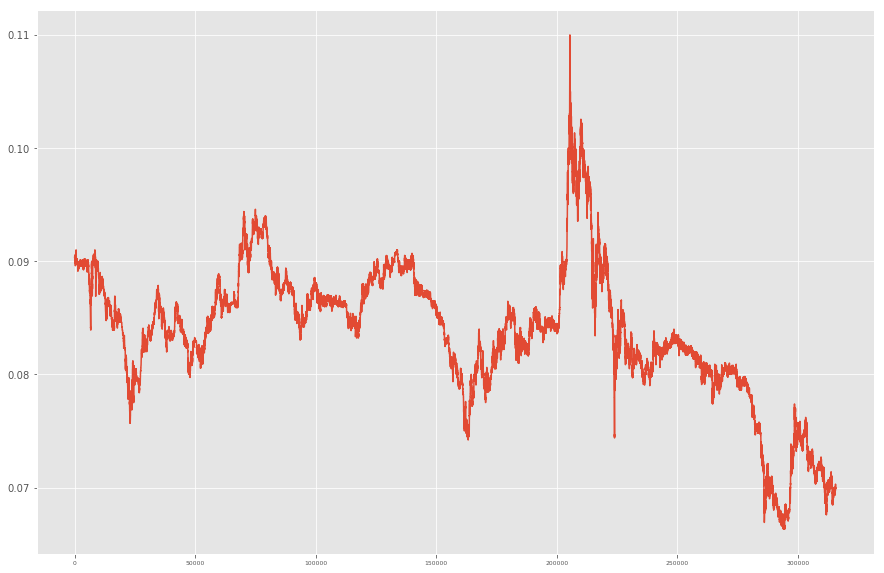

In [11]:
# TODO: Draw 3 lines with last in Y and timestamp in x

# TODO: Draw more lines with bid, ask, volumes, to try to find correlations

# TODO: Basic regression and accuracy. / graphs


# TODO: Get Orderbook/historical trades/chart... to try to find proxies for price.
plt.figure(figsize=(15,10))
plt.style.use('ggplot')
plt.plot(df.index, df['last'])
    
#Change font size of x-axis    
plt.tick_params(axis='x', which='major', labelsize=6)



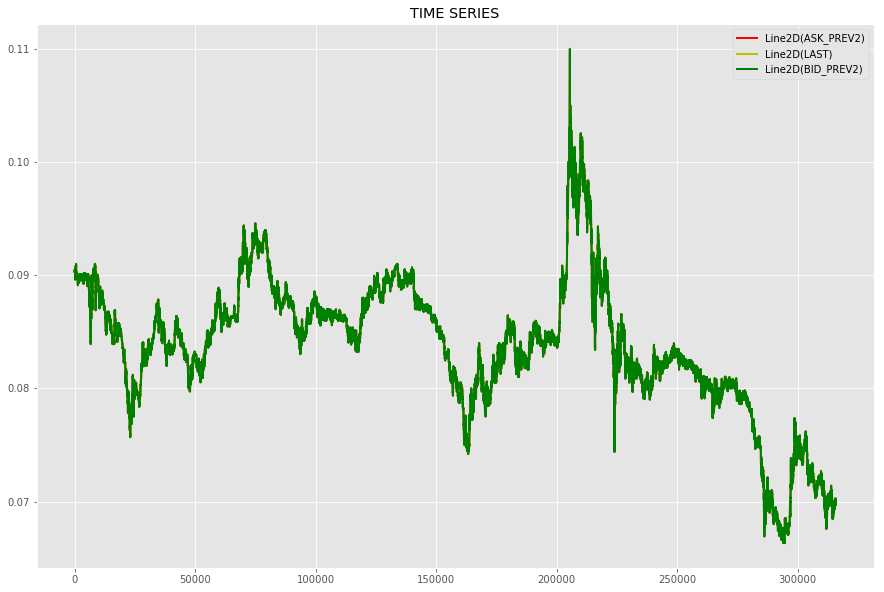

In [12]:
n=2

plt.figure(figsize=(15,10))
line1,=plt.plot(df['last_prev{}'.format(n)],linewidth=2,color='r',label='ASK_PREV{}'.format(n))
# line2,=plt.plot(df['last_prev{}'.format(n)],linewidth=2,color='b',label='LAST_PREV{}'.format(n))
line3,=plt.plot(df['last'],linewidth=2,color='y',label='LAST')
line4,=plt.plot(df['last_next{}'.format(n)],linewidth=2,color='g',label='BID_PREV{}'.format(n))
plt.title("TIME SERIES")
plt.legend([line1, line3, line4])
plt.show()
# print('Accuracy Train:',1-np.mean(abs(trainPredict-trainY)))
# print('Accuracy Test:',1-np.mean(abs(testPredict-testY)))

### COMMON ML STUFF

#### TODO ADD ASK/BID/OPEN BUY/OPEN SELL

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
# We now need it to be in the same order as the original model.
dataset = df

In [15]:
dataset.shape

(315616, 166)

In [16]:
dataset_np = dataset.values
dataset_np = dataset_np.astype('float32')
dataset_np[:10,102]

array([ 0.09035811,  0.09035811,  0.09035811,  0.09035811,  0.09035811,
        0.09035811,  0.09035811,  0.09035811,  0.09035811,  0.09035811], dtype=float32)

In [17]:
def create_dataset(_dataset, y_position, _datapoints_forward):
    dataX, dataY = _dataset[:,0:_dataset.shape[1]-_datapoints_forward], _dataset[:,y_position].reshape(_dataset.shape[0],1)
    return dataX, dataY

In [18]:
n_predictions = len(y_select)

y_position = [None] * n_predictions
datapoints_forward_prediction = [None] * n_predictions
X_pre_scale = [None] * n_predictions
Y_pre_scale = [None] * n_predictions


In [19]:
for i in range(n_predictions):
    y_position[i] = dataset_np.shape[1]-(1+datapoints_forward-y_select[i])
    datapoints_forward_prediction[i] = y_position[i] - (dataset_np.shape[1]-1+datapoints_forward)

    X_pre_scale[i], Y_pre_scale[i] = create_dataset(dataset_np, y_position[i], datapoints_forward)
    print(Y_pre_scale[i].shape)

(315616, 1)
(315616, 1)
(315616, 1)
(315616, 1)
(315616, 1)
(315616, 1)


### FEATURE ENGINEERING

In [20]:
columns = list(dataset.columns.values)
current_price_ds_ilocation = columns.index('ask')

In [21]:
X = [None] * n_predictions
y = [None] * n_predictions
f_select_f_regression = [None] * n_predictions
f_select_mutual_info = [None] * n_predictions
list_f_select_f_regression = [None] * n_predictions
list_f_select_mutual_info = [None] * n_predictions
f_selector_mdl = [None] * n_predictions
current_price_ilocation = [None] * n_predictions
X_new = [None] * n_predictions

In [22]:
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.feature_selection import SelectKBest

for i in range(n_predictions):
    X[i], y[i] = X_pre_scale[i], Y_pre_scale[i].reshape(Y_pre_scale[i].shape[0],)
    print(X[i].shape)
    
        # It's to expensive to calculate, so we won't do it on a daily basis
#     f_select_f_regression[i] = SelectKBest(f_regression, k=x_features).fit(X[i], y[i])
#     f_select_mutual_info[i] = SelectKBest(mutual_info_regression, k=x_features).fit(X[i], y[i])
    
    f_select_f_regression[i] = joblib.load('../models/latest/fe/f_select_f_regression_{}_{}_{}_{}_fileslb_{}_datalb_{}_predictlf_{}.pkl'.format(
                    pair, n_columns_f_selection, y_select[i], yesterday.strftime('%Y%m%d'), days_back_file*-1, datapoints_back, y_select[i])) 


    f_select_mutual_info[i] = joblib.load('../models/latest/fe/f_select_mutual_info_{}_{}_{}_{}_fileslb_{}_datalb_{}_predictlf_{}.pkl'.format(
                    pair, n_columns_f_selection,  y_select[i], yesterday.strftime('%Y%m%d'), days_back_file*-1, datapoints_back, y_select[i]))
        
    list_f_select_f_regression[i] = list(f_select_f_regression[i].get_support(indices=True))
    list_f_select_mutual_info[i] = list(f_select_mutual_info[i].get_support(indices=True))
    
    if feature_selector == 'f_regression':
        f_selector_mdl[i] = f_select_f_regression[i]
        current_price_ilocation[i] = list_f_select_f_regression[i].index(current_price_ds_ilocation)
    if feature_selector == 'mutual_info_regression':
        f_selector_mdl[i] = f_select_mutual_info[i]
        current_price_ilocation[i] = list_f_select_mutual_info[i].index(current_price_ds_ilocation)


    X_new[i] = f_selector_mdl[i].transform(X[i])
    print(X_new[i].shape)
    
    joblib.dump(f_select_f_regression[i], 
            '../models/latest/fe/f_select_f_regression_{}_{}_{}_{}_fileslb_{}_datalb_{}_predictlf_{}.pkl'.format(
            pair, n_columns_f_selection, y_select[i], yesterday.strftime('%Y%m%d'), days_back_file*-1, datapoints_back, y_select[i]))

    joblib.dump(f_select_mutual_info[i], 
            '../models/latest/fe/f_select_mutual_info_{}_{}_{}_{}_fileslb_{}_datalb_{}_predictlf_{}.pkl'.format(
            pair, n_columns_f_selection, y_select[i], yesterday.strftime('%Y%m%d'), days_back_file*-1, datapoints_back, y_select[i]))
    
    for param_pair in zip(list_f_select_f_regression[i], list_f_select_mutual_info[i]):
        print("f_regression:{}:{}........mutual_info:{}:{}".format(param_pair[0], columns[param_pair[0]], 
                                                                   param_pair[1], columns[param_pair[1]]))

(315616, 160)
(315616, 50)
f_regression:0:ask........mutual_info:0:ask
f_regression:2:bid........mutual_info:1:base_volume
f_regression:4:last........mutual_info:2:bid
f_regression:7:open_sell_orders........mutual_info:4:last
f_regression:10:ask_prev1........mutual_info:9:volume
f_regression:11:ask_prev2........mutual_info:10:ask_prev1
f_regression:12:ask_prev3........mutual_info:11:ask_prev2
f_regression:16:bid_prev1........mutual_info:12:ask_prev3
f_regression:17:bid_prev2........mutual_info:13:base_volume_prev1
f_regression:18:bid_prev3........mutual_info:14:base_volume_prev2
f_regression:22:last_prev1........mutual_info:15:base_volume_prev3
f_regression:23:last_prev2........mutual_info:16:bid_prev1
f_regression:24:last_prev3........mutual_info:17:bid_prev2
f_regression:31:open_sell_orders_prev1........mutual_info:18:bid_prev3
f_regression:40:ask_prev4........mutual_info:37:volume_prev1
f_regression:41:ask_prev5........mutual_info:38:volume_prev2
f_regression:42:ask_prev6........mut

### SCALERS AND DATASETS

In [23]:
def get_scalers_and_datasets(_X_pre_scale, _Y_pre_scale, _scalers_base_path, i):
#     _scaler_X = joblib.load(_scalers_base_path.format('scalerX'))
#     _scaler_Y = joblib.load(_scalers_base_path.format('scalerY'))
    _scaler_X = MinMaxScaler(feature_range=(0, 1))
    _scaler_Y = MinMaxScaler(feature_range=(0, 1))
    _scaled_X_dataset_np = _scaler_X.fit(_X_pre_scale)
    _scaled_Y_dataset_np = _scaler_Y.fit(_Y_pre_scale)
    joblib.dump(_scaler_X, _scalers_base_path.format('scalerX'))

    joblib.dump(_scaler_Y, _scalers_base_path.format('scalerY'))

    print(_scaler_Y)
    _scaled_X_dataset_np = _scaler_X.transform(_X_pre_scale)
    _scaled_Y_dataset_np = _scaler_Y.transform(_Y_pre_scale)
    return (_scaler_X, _scaler_Y, _scaled_X_dataset_np, _scaled_Y_dataset_np)

In [24]:
scaler_base_path = [None] * n_predictions
scaler_X = [None] * n_predictions
scaler_Y = [None] * n_predictions
scaled_X_dataset_np = [None] * n_predictions
scaled_Y_dataset_np = [None] * n_predictions

In [25]:
for i in range(n_predictions):
    scaler_base_path[i] = '../models/latest/fe/minmax_{{}}_{}_{}_{}_{}_{}_fileslb_{}_datalb_{}_predictlf_{}.pkl'.format(
                    pair, feature_selector, n_columns_f_selection, y_select[i], yesterday.strftime('%Y%m%d'), days_back_file*-1, \
                    datapoints_back, y_select[i])
    print(Y_pre_scale[i].shape)
    scaler_X[i], scaler_Y[i], scaled_X_dataset_np[i], scaled_Y_dataset_np[i] = get_scalers_and_datasets(X_new[i], Y_pre_scale[i], 
                                                                                            scaler_base_path[i], i)
    
    print(scaled_X_dataset_np[i].shape)

(315616, 1)
MinMaxScaler(copy=True, feature_range=(0, 1))
(315616, 50)
(315616, 1)
MinMaxScaler(copy=True, feature_range=(0, 1))
(315616, 50)
(315616, 1)
MinMaxScaler(copy=True, feature_range=(0, 1))
(315616, 50)
(315616, 1)
MinMaxScaler(copy=True, feature_range=(0, 1))
(315616, 50)
(315616, 1)
MinMaxScaler(copy=True, feature_range=(0, 1))
(315616, 50)
(315616, 1)
MinMaxScaler(copy=True, feature_range=(0, 1))
(315616, 50)


In [26]:
def get_train_test_scaled_datasets(_scaled_X_dataset_np, _scaled_Y_dataset_np):
    np.random.seed(7)
     # We temporarily use almost all the data for training
    train_size = int(len(_scaled_X_dataset_np) * 0.99)
    test_size = len(_scaled_X_dataset_np) - train_size
    _trainX, _testX = _scaled_X_dataset_np[0:train_size,:], _scaled_X_dataset_np[train_size:len(_scaled_X_dataset_np),:]
    _trainY, _testY = _scaled_Y_dataset_np[0:train_size,:], _scaled_Y_dataset_np[train_size:len(_scaled_Y_dataset_np),:]
    return _trainX, _testX, _trainY, _testY

### RANDOM FOREST REGRESSOR

In [27]:
from sklearn.ensemble import RandomForestRegressor
import math


trainX = [None] * n_predictions
testX = [None] * n_predictions
trainY = [None] * n_predictions
testY = [None] * n_predictions

forest_reg = [None] * n_predictions
trainPredict = [None] * n_predictions
testPredict = [None] * n_predictions

trainScore = [None] * n_predictions
testScore = [None] * n_predictions

pd_validation_random_forest  = [None] * n_predictions

[[ 0.07684577  0.07684577  0.07684577  0.07684577  0.07684577  0.07684577]
 [ 0.07684577  0.07684577  0.07684577  0.07684577  0.07684577  0.07684577]
 [ 0.07077003  0.07077003  0.07077003  0.07077003  0.07077003  0.07077003]
 ..., 
 [ 0.0905894   0.0905894   0.0905894   0.0905894   0.0905894   0.0905894 ]
 [ 0.09059     0.09059     0.09059     0.09059     0.09059     0.09059   ]
 [ 0.09059     0.09059     0.09059     0.09059     0.09059     0.09059   ]]
(3157, 1)


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


(3157,)
Train Score: 0.00004 RMSE
Test Score: 0.00018 RMSE
     actual      last  predicted
0  0.069435  0.069700   0.069533
1  0.069400  0.069700   0.069538
2  0.069400  0.069435   0.069580
3  0.069400  0.069700   0.069436
4  0.069680  0.069700   0.069511
5  0.069680  0.069680   0.069511
6  0.069323  0.069680   0.069548
7  0.069680  0.069680   0.069532
8  0.069680  0.069680   0.069532
9  0.069680  0.069680   0.069527


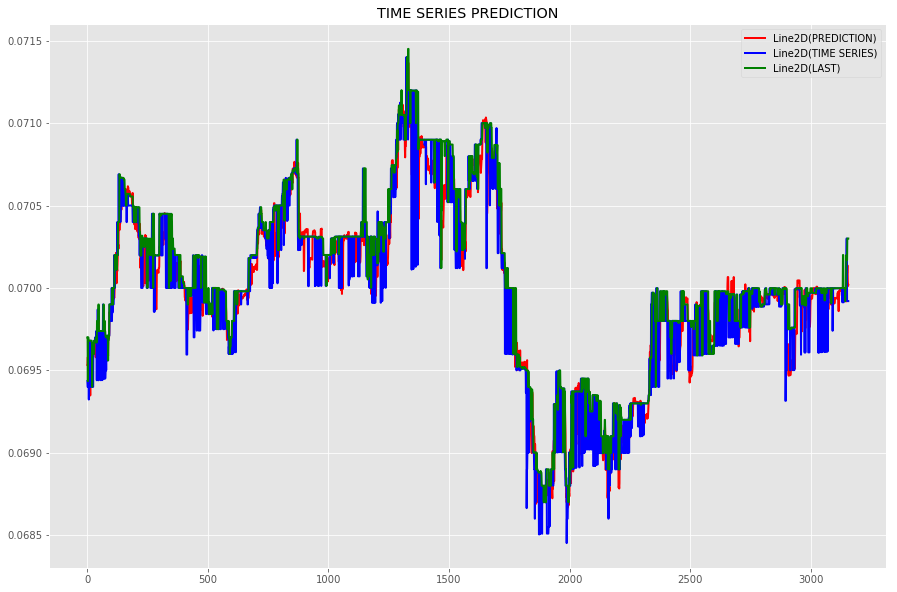

[[ 0.07684577  0.07684577  0.07684577  0.07684577  0.07684577  0.07684577]
 [ 0.07684577  0.07684577  0.07684577  0.07684577  0.07684577  0.07684577]
 [ 0.07077003  0.07077003  0.07077003  0.07077003  0.07077003  0.07077003]
 ..., 
 [ 0.0905894   0.0905894   0.0905894   0.0905894   0.0905894   0.0905894 ]
 [ 0.09059     0.09059     0.09059     0.09059     0.09059     0.09059   ]
 [ 0.09059     0.09059     0.09059     0.09059     0.09059     0.09059   ]]
(3157, 1)


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


(3157,)
Train Score: 0.00004 RMSE
Test Score: 0.00021 RMSE
     actual      last  predicted
0  0.069680  0.069700   0.069602
1  0.069323  0.069700   0.069610
2  0.069680  0.069435   0.069575
3  0.069680  0.069700   0.069554
4  0.069680  0.069700   0.069584
5  0.069680  0.069680   0.069584
6  0.069400  0.069680   0.069559
7  0.069680  0.069680   0.069551
8  0.069680  0.069680   0.069558
9  0.069680  0.069680   0.069490


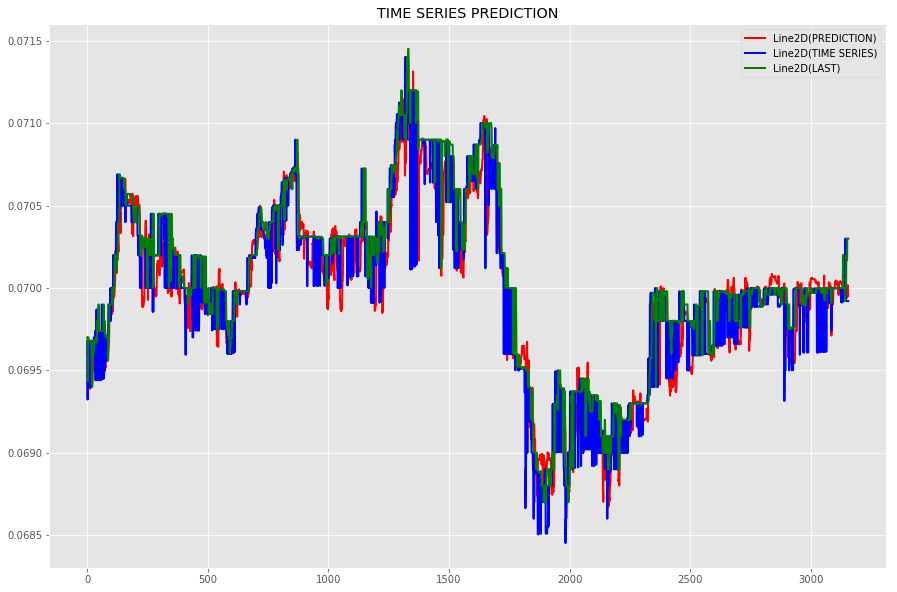

[[ 0.07684577  0.07684577  0.07684577  0.07684577  0.07684577  0.07684577]
 [ 0.07684577  0.07684577  0.07684577  0.07684577  0.07684577  0.07684577]
 [ 0.07077003  0.07077003  0.07077003  0.07077003  0.07077003  0.07077003]
 ..., 
 [ 0.0905894   0.0905894   0.0905894   0.0905894   0.0905894   0.0905894 ]
 [ 0.09059     0.09059     0.09059     0.09059     0.09059     0.09059   ]
 [ 0.09059     0.09059     0.09059     0.09059     0.09059     0.09059   ]]
(3157, 1)


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


(3157,)
Train Score: 0.00005 RMSE
Test Score: 0.00028 RMSE
    actual      last  predicted
0  0.06968  0.069700   0.069535
1  0.06968  0.069700   0.069577
2  0.06968  0.069435   0.069483
3  0.06968  0.069700   0.069505
4  0.06940  0.069700   0.069519
5  0.06940  0.069680   0.069470
6  0.06940  0.069680   0.069464
7  0.06940  0.069680   0.069464
8  0.06940  0.069680   0.069480
9  0.06940  0.069680   0.069488


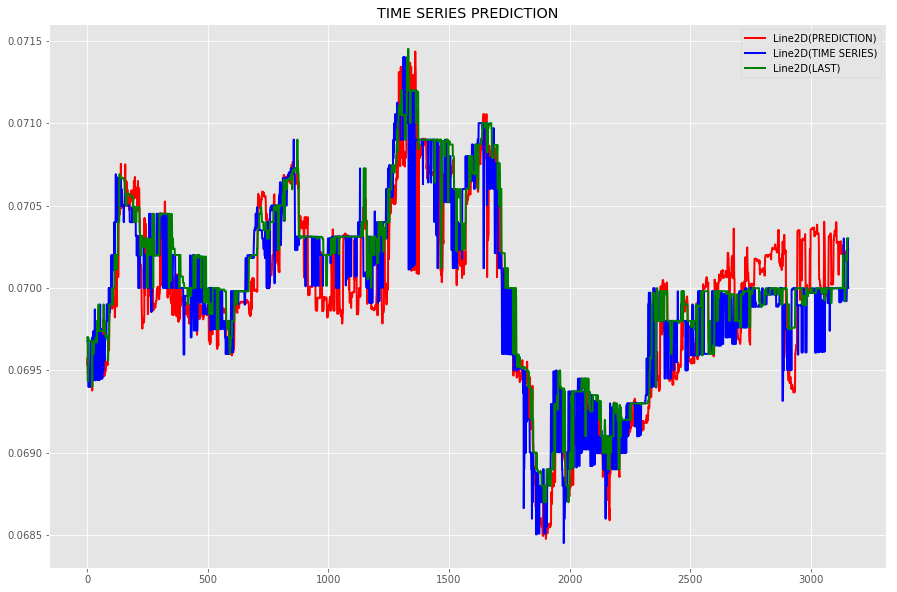

[[ 0.07684577  0.07684577  0.07684577  0.07684577  0.07684577  0.07684577]
 [ 0.07684577  0.07684577  0.07684577  0.07684577  0.07684577  0.07684577]
 [ 0.07077003  0.07077003  0.07077003  0.07077003  0.07077003  0.07077003]
 ..., 
 [ 0.0905894   0.0905894   0.0905894   0.0905894   0.0905894   0.0905894 ]
 [ 0.09059     0.09059     0.09059     0.09059     0.09059     0.09059   ]
 [ 0.09059     0.09059     0.09059     0.09059     0.09059     0.09059   ]]
(3157, 1)


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


(3157,)
Train Score: 0.00004 RMSE
Test Score: 0.00030 RMSE
     actual      last  predicted
0  0.069400  0.069700   0.069483
1  0.069400  0.069700   0.069464
2  0.069400  0.069435   0.069387
3  0.069400  0.069700   0.069359
4  0.069669  0.069700   0.069419
5  0.069669  0.069680   0.069423
6  0.069669  0.069680   0.069408
7  0.069680  0.069680   0.069438
8  0.069669  0.069680   0.069443
9  0.069669  0.069680   0.069394


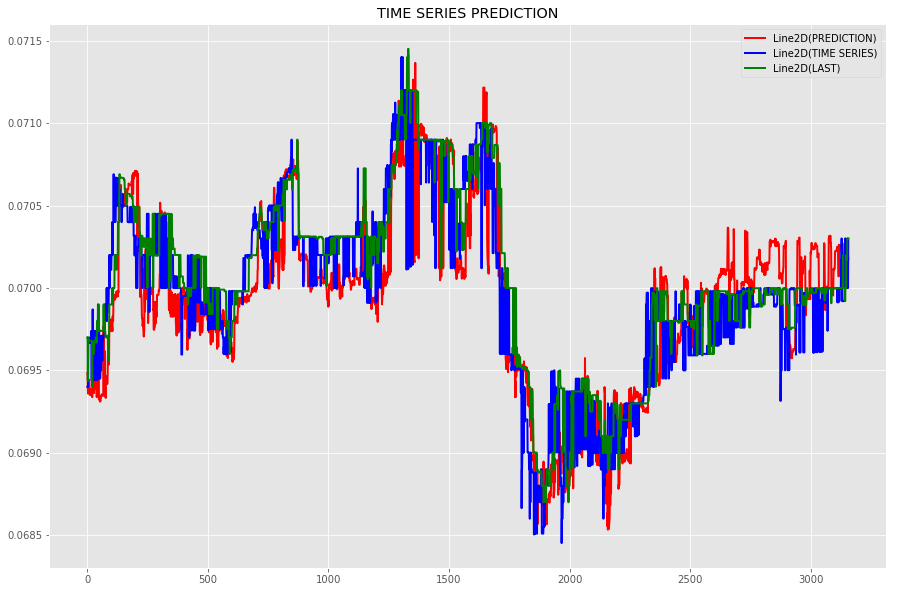

[[ 0.07684577  0.07684577  0.07684577  0.07684577  0.07684577  0.07684577]
 [ 0.07684577  0.07684577  0.07684577  0.07684577  0.07684577  0.07684577]
 [ 0.07077003  0.07077003  0.07077003  0.07077003  0.07077003  0.07077003]
 ..., 
 [ 0.0905894   0.0905894   0.0905894   0.0905894   0.0905894   0.0905894 ]
 [ 0.09059     0.09059     0.09059     0.09059     0.09059     0.09059   ]
 [ 0.09059     0.09059     0.09059     0.09059     0.09059     0.09059   ]]
(3157, 1)


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


(3157,)
Train Score: 0.00004 RMSE
Test Score: 0.00034 RMSE
     actual      last  predicted
0  0.069700  0.069700   0.069651
1  0.069700  0.069700   0.069575
2  0.069700  0.069435   0.069587
3  0.069669  0.069700   0.069513
4  0.069669  0.069700   0.069546
5  0.069739  0.069680   0.069532
6  0.069739  0.069680   0.069523
7  0.069440  0.069680   0.069523
8  0.069739  0.069680   0.069523
9  0.069739  0.069680   0.069503


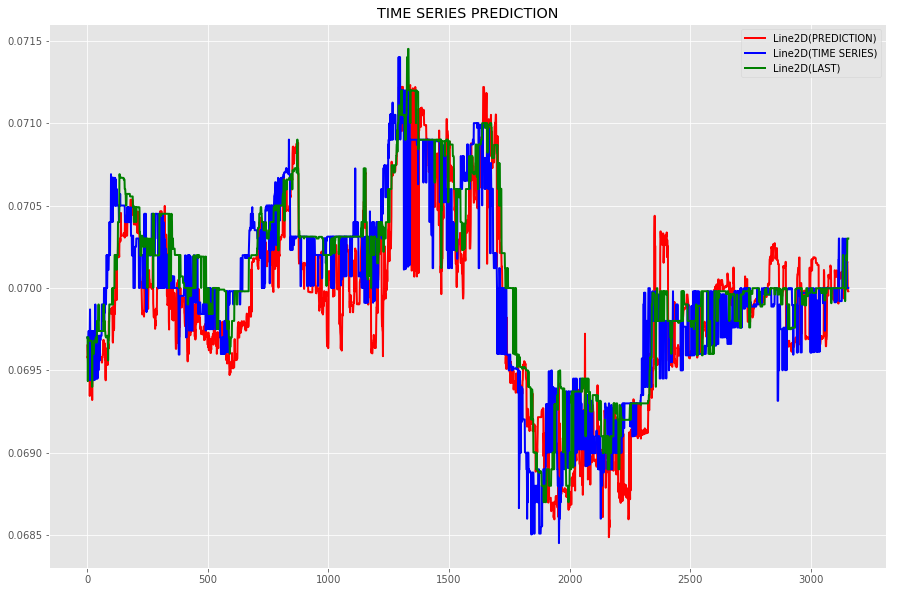

[[ 0.07684577  0.07684577  0.07684577  0.07684577  0.07684577  0.07684577]
 [ 0.07684577  0.07684577  0.07684577  0.07684577  0.07684577  0.07684577]
 [ 0.07077003  0.07077003  0.07077003  0.07077003  0.07077003  0.07077003]
 ..., 
 [ 0.0905894   0.0905894   0.0905894   0.0905894   0.0905894   0.0905894 ]
 [ 0.09059     0.09059     0.09059     0.09059     0.09059     0.09059   ]
 [ 0.09059     0.09059     0.09059     0.09059     0.09059     0.09059   ]]
(3157, 1)


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


(3157,)
Train Score: 0.00004 RMSE
Test Score: 0.00041 RMSE
     actual      last  predicted
0  0.069440  0.069700   0.069711
1  0.069440  0.069700   0.069719
2  0.069440  0.069435   0.069687
3  0.069739  0.069700   0.069673
4  0.069739  0.069700   0.069694
5  0.069739  0.069680   0.069654
6  0.069739  0.069680   0.069671
7  0.069739  0.069680   0.069678
8  0.069739  0.069680   0.069678
9  0.069739  0.069680   0.069535


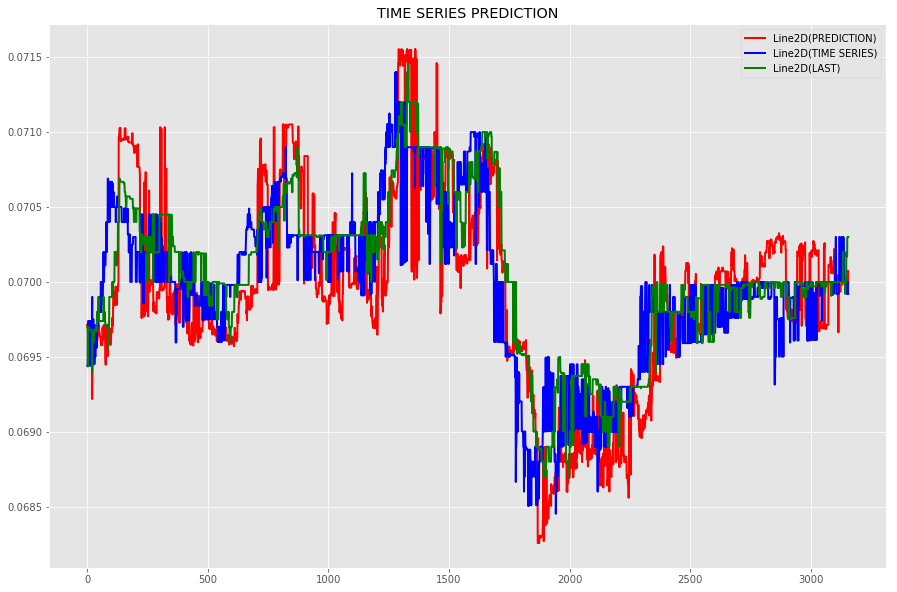

In [28]:
for i in range(n_predictions):
    trainX[i], testX[i], trainY[i], testY[i] = get_train_test_scaled_datasets(scaled_X_dataset_np[i], scaled_Y_dataset_np[i])
    print(testX[i][:,current_price_ilocation])
    print(testY[i].shape)
    
    forest_reg[i] = RandomForestRegressor(n_estimators=20)
    forest_reg[i].fit(trainX[i], trainY[i])
    
#     forest_reg[i] = joblib.load( 
#             '../models/latest/random_forest_regressor/random_forest_regressor_{}_{}_{}_{}_{}_fileslb_{}_datalb_{}_predictlf_{}.pkl'.format(
#                 pair, feature_selector, n_columns_f_selection, y_select[i], yesterday.strftime('%Y%m%d'), days_back_file*-1, datapoints_back, y_select[i]))
    
    joblib.dump(forest_reg[i], 
            '../models/latest/random_forest_regressor/random_forest_regressor_{}_{}_{}_{}_{}_fileslb_{}_datalb_{}_predictlf_{}.pkl'.format(
                pair, feature_selector, n_columns_f_selection, y_select[i], yesterday.strftime('%Y%m%d'), days_back_file*-1, datapoints_back, y_select[i]))
    
    trainPredict[i] = forest_reg[i].predict(trainX[i])
    testPredict[i] = forest_reg[i].predict(testX[i])
    
    trainPredict[i] = scaler_Y[i].inverse_transform(trainPredict[i])
    trainX[i] = scaler_X[i].inverse_transform(trainX[i])
    trainY[i] = scaler_Y[i].inverse_transform(trainY[i])
    testPredict[i] = scaler_Y[i].inverse_transform(testPredict[i])
    testX[i] = scaler_X[i].inverse_transform(testX[i])
    testY[i] = scaler_Y[i].inverse_transform(testY[i])
    
    print (testPredict[i].shape)
    
    # calculate root mean squared error
    trainScore[i] = math.sqrt(mean_squared_error(trainY[i][:,0], trainPredict[i]))
    print('Train Score: %.5f RMSE' % (trainScore[i]))
    testScore[i] = math.sqrt(mean_squared_error(testY[i][:,0], testPredict[i]))
    print('Test Score: %.5f RMSE' % (testScore[i]))
    
    pd_validation_random_forest[i] = pd.DataFrame({'predicted': testPredict[i], \
                                  'actual': testY[i][:,0], 'last': testX[i][:, current_price_ilocation[i]]})
    
    print(pd_validation_random_forest[i].head(10))
    
    plt.figure(figsize=(15,10))
    line1,=plt.plot(pd_validation_random_forest[i]['predicted'],linewidth=2,color='r',label='PREDICTION')
    line2,=plt.plot(pd_validation_random_forest[i]['actual'],linewidth=2,color='b',label='TIME SERIES')
    line3,=plt.plot(pd_validation_random_forest[i]['last'],linewidth=2,color='g',label='LAST')
    plt.title("TIME SERIES PREDICTION")
    plt.legend([line1, line2, line3])
    plt.show()

### XGBOOST

In [29]:
import xgboost as xgb
import math


trainX = [None] * n_predictions
testX = [None] * n_predictions
trainY = [None] * n_predictions
testY = [None] * n_predictions

clf = [None] * n_predictions
xgb_reg = [None] * n_predictions
trainPredict = [None] * n_predictions
testPredict = [None] * n_predictions

trainScore = [None] * n_predictions
testScore = [None] * n_predictions

pd_validation_xgb  = [None] * n_predictions

[[ 0.07684577  0.07684577  0.07684577  0.07684577  0.07684577  0.07684577]
 [ 0.07684577  0.07684577  0.07684577  0.07684577  0.07684577  0.07684577]
 [ 0.07077003  0.07077003  0.07077003  0.07077003  0.07077003  0.07077003]
 ..., 
 [ 0.0905894   0.0905894   0.0905894   0.0905894   0.0905894   0.0905894 ]
 [ 0.09059     0.09059     0.09059     0.09059     0.09059     0.09059   ]
 [ 0.09059     0.09059     0.09059     0.09059     0.09059     0.09059   ]]
(3157, 1)
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  7.6min finished


0.964539612902
{'n_estimators': 100, 'max_depth': 4}


/opt/conda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


(3157,)
Train Score: 0.00014 RMSE
Test Score: 0.00018 RMSE
     actual      last  predicted
0  0.069435  0.069700   0.069670
1  0.069400  0.069700   0.069670
2  0.069400  0.069435   0.069421
3  0.069400  0.069700   0.069401
4  0.069680  0.069700   0.069447
5  0.069680  0.069680   0.069447
6  0.069323  0.069680   0.069433
7  0.069680  0.069680   0.069433
8  0.069680  0.069680   0.069433
9  0.069680  0.069680   0.069433


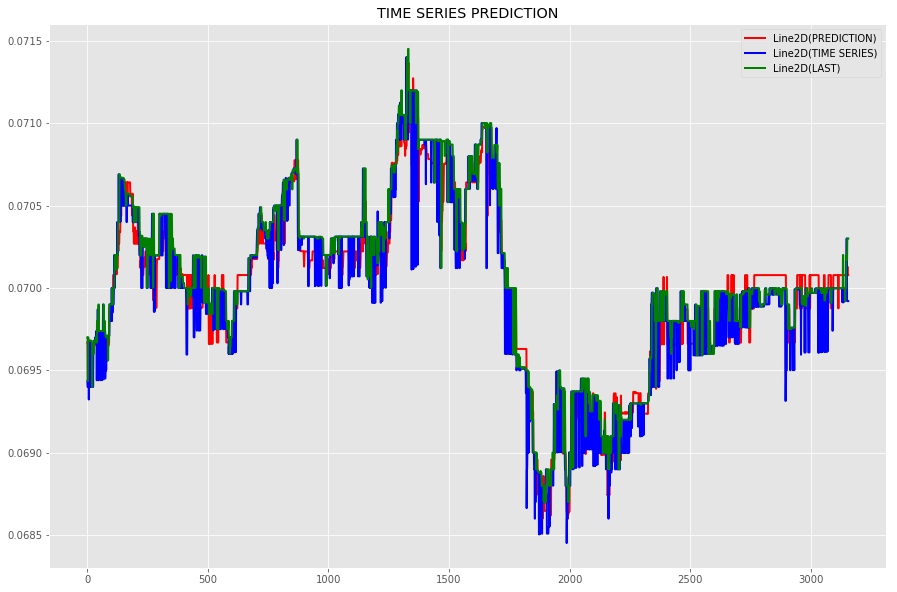

[[ 0.07684577  0.07684577  0.07684577  0.07684577  0.07684577  0.07684577]
 [ 0.07684577  0.07684577  0.07684577  0.07684577  0.07684577  0.07684577]
 [ 0.07077003  0.07077003  0.07077003  0.07077003  0.07077003  0.07077003]
 ..., 
 [ 0.0905894   0.0905894   0.0905894   0.0905894   0.0905894   0.0905894 ]
 [ 0.09059     0.09059     0.09059     0.09059     0.09059     0.09059   ]
 [ 0.09059     0.09059     0.09059     0.09059     0.09059     0.09059   ]]
(3157, 1)
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  7.4min finished


0.961790398675
{'n_estimators': 50, 'max_depth': 6}


/opt/conda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


(3157,)
Train Score: 0.00018 RMSE
Test Score: 0.00019 RMSE
     actual      last  predicted
0  0.069680  0.069700   0.069666
1  0.069323  0.069700   0.069676
2  0.069680  0.069435   0.069618
3  0.069680  0.069700   0.069531
4  0.069680  0.069700   0.069620
5  0.069680  0.069680   0.069610
6  0.069400  0.069680   0.069610
7  0.069680  0.069680   0.069610
8  0.069680  0.069680   0.069610
9  0.069680  0.069680   0.069610


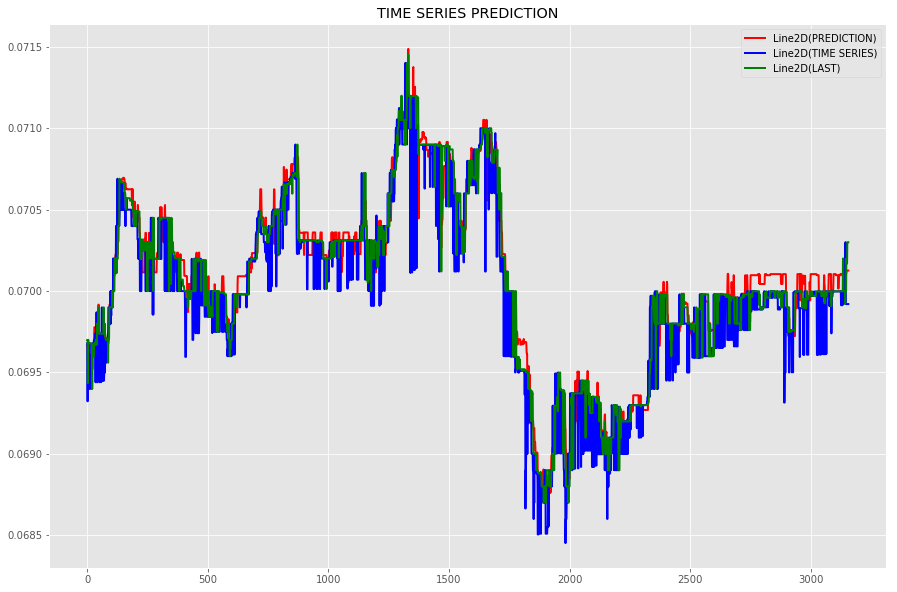

[[ 0.07684577  0.07684577  0.07684577  0.07684577  0.07684577  0.07684577]
 [ 0.07684577  0.07684577  0.07684577  0.07684577  0.07684577  0.07684577]
 [ 0.07077003  0.07077003  0.07077003  0.07077003  0.07077003  0.07077003]
 ..., 
 [ 0.0905894   0.0905894   0.0905894   0.0905894   0.0905894   0.0905894 ]
 [ 0.09059     0.09059     0.09059     0.09059     0.09059     0.09059   ]
 [ 0.09059     0.09059     0.09059     0.09059     0.09059     0.09059   ]]
(3157, 1)
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  7.3min finished


0.960077785646
{'n_estimators': 200, 'max_depth': 2}


/opt/conda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


(3157,)
Train Score: 0.00024 RMSE
Test Score: 0.00023 RMSE
    actual      last  predicted
0  0.06968  0.069700   0.069607
1  0.06968  0.069700   0.069607
2  0.06968  0.069435   0.069360
3  0.06968  0.069700   0.069607
4  0.06940  0.069700   0.069607
5  0.06940  0.069680   0.069607
6  0.06940  0.069680   0.069607
7  0.06940  0.069680   0.069607
8  0.06940  0.069680   0.069607
9  0.06940  0.069680   0.069607


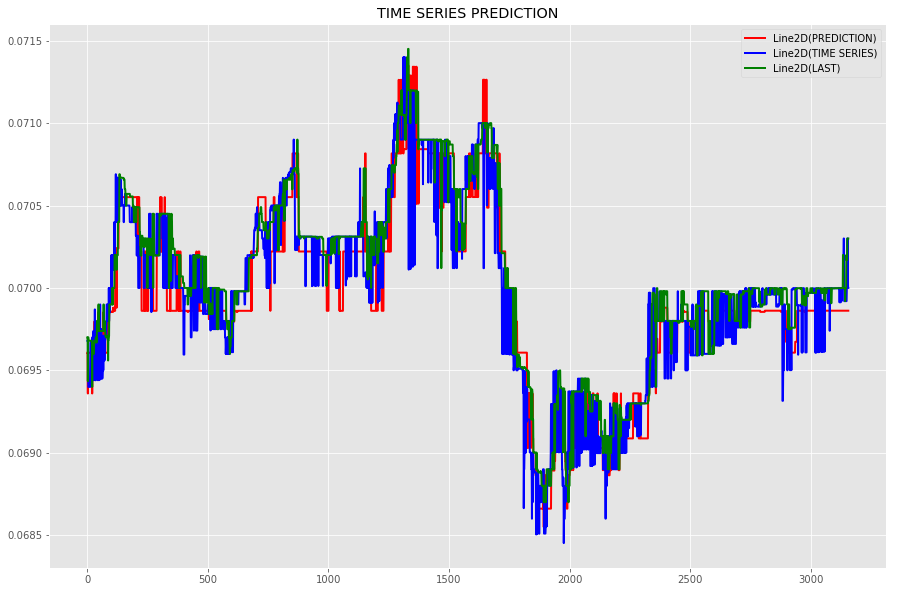

[[ 0.07684577  0.07684577  0.07684577  0.07684577  0.07684577  0.07684577]
 [ 0.07684577  0.07684577  0.07684577  0.07684577  0.07684577  0.07684577]
 [ 0.07077003  0.07077003  0.07077003  0.07077003  0.07077003  0.07077003]
 ..., 
 [ 0.0905894   0.0905894   0.0905894   0.0905894   0.0905894   0.0905894 ]
 [ 0.09059     0.09059     0.09059     0.09059     0.09059     0.09059   ]
 [ 0.09059     0.09059     0.09059     0.09059     0.09059     0.09059   ]]
(3157, 1)
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  7.2min finished


0.956004898393
{'n_estimators': 200, 'max_depth': 4}


/opt/conda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


(3157,)
Train Score: 0.00024 RMSE
Test Score: 0.00026 RMSE
     actual      last  predicted
0  0.069400  0.069700   0.069455
1  0.069400  0.069700   0.069455
2  0.069400  0.069435   0.069455
3  0.069400  0.069700   0.069455
4  0.069669  0.069700   0.069455
5  0.069669  0.069680   0.069455
6  0.069669  0.069680   0.069455
7  0.069680  0.069680   0.069455
8  0.069669  0.069680   0.069455
9  0.069669  0.069680   0.069455


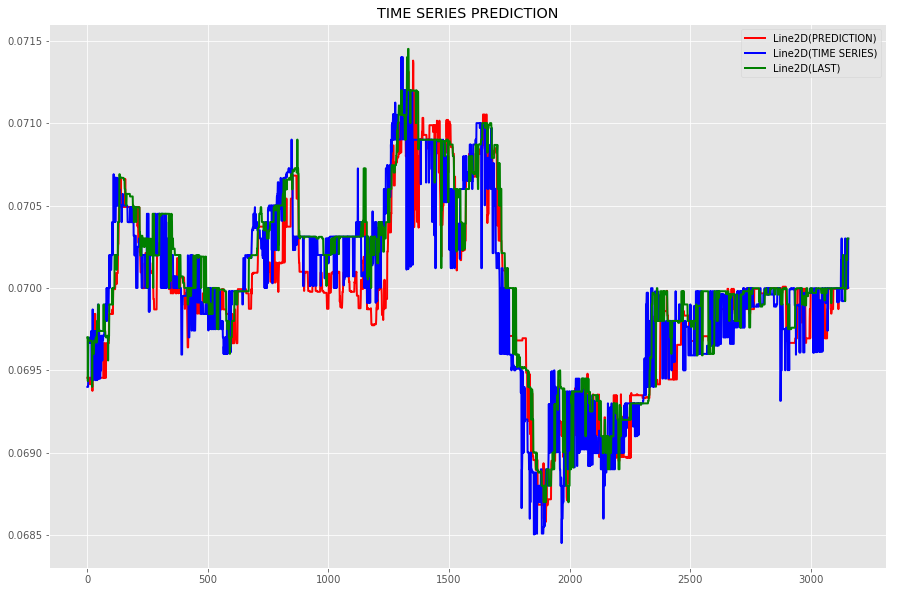

[[ 0.07684577  0.07684577  0.07684577  0.07684577  0.07684577  0.07684577]
 [ 0.07684577  0.07684577  0.07684577  0.07684577  0.07684577  0.07684577]
 [ 0.07077003  0.07077003  0.07077003  0.07077003  0.07077003  0.07077003]
 ..., 
 [ 0.0905894   0.0905894   0.0905894   0.0905894   0.0905894   0.0905894 ]
 [ 0.09059     0.09059     0.09059     0.09059     0.09059     0.09059   ]
 [ 0.09059     0.09059     0.09059     0.09059     0.09059     0.09059   ]]
(3157, 1)
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  7.4min finished


0.953831912787
{'n_estimators': 200, 'max_depth': 2}


/opt/conda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


(3157,)
Train Score: 0.00032 RMSE
Test Score: 0.00029 RMSE
     actual      last  predicted
0  0.069700  0.069700   0.069458
1  0.069700  0.069700   0.069458
2  0.069700  0.069435   0.069458
3  0.069669  0.069700   0.069458
4  0.069669  0.069700   0.069458
5  0.069739  0.069680   0.069458
6  0.069739  0.069680   0.069458
7  0.069440  0.069680   0.069458
8  0.069739  0.069680   0.069458
9  0.069739  0.069680   0.069458


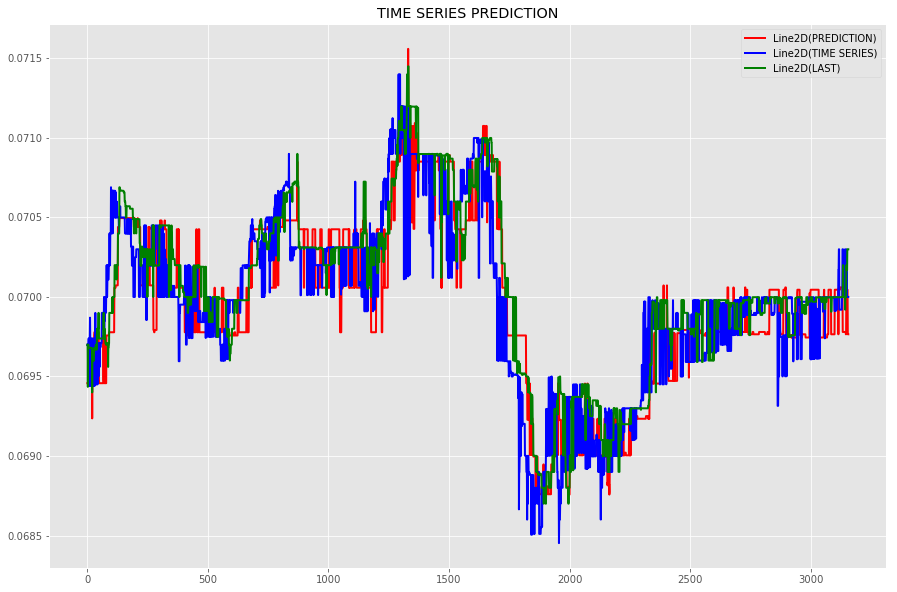

[[ 0.07684577  0.07684577  0.07684577  0.07684577  0.07684577  0.07684577]
 [ 0.07684577  0.07684577  0.07684577  0.07684577  0.07684577  0.07684577]
 [ 0.07077003  0.07077003  0.07077003  0.07077003  0.07077003  0.07077003]
 ..., 
 [ 0.0905894   0.0905894   0.0905894   0.0905894   0.0905894   0.0905894 ]
 [ 0.09059     0.09059     0.09059     0.09059     0.09059     0.09059   ]
 [ 0.09059     0.09059     0.09059     0.09059     0.09059     0.09059   ]]
(3157, 1)
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  7.6min finished


0.949715860933
{'n_estimators': 200, 'max_depth': 2}


/opt/conda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


(3157,)
Train Score: 0.00036 RMSE
Test Score: 0.00033 RMSE
     actual      last  predicted
0  0.069440  0.069700   0.069560
1  0.069440  0.069700   0.069560
2  0.069440  0.069435   0.069293
3  0.069739  0.069700   0.069560
4  0.069739  0.069700   0.069560
5  0.069739  0.069680   0.069560
6  0.069739  0.069680   0.069560
7  0.069739  0.069680   0.069560
8  0.069739  0.069680   0.069560
9  0.069739  0.069680   0.069560


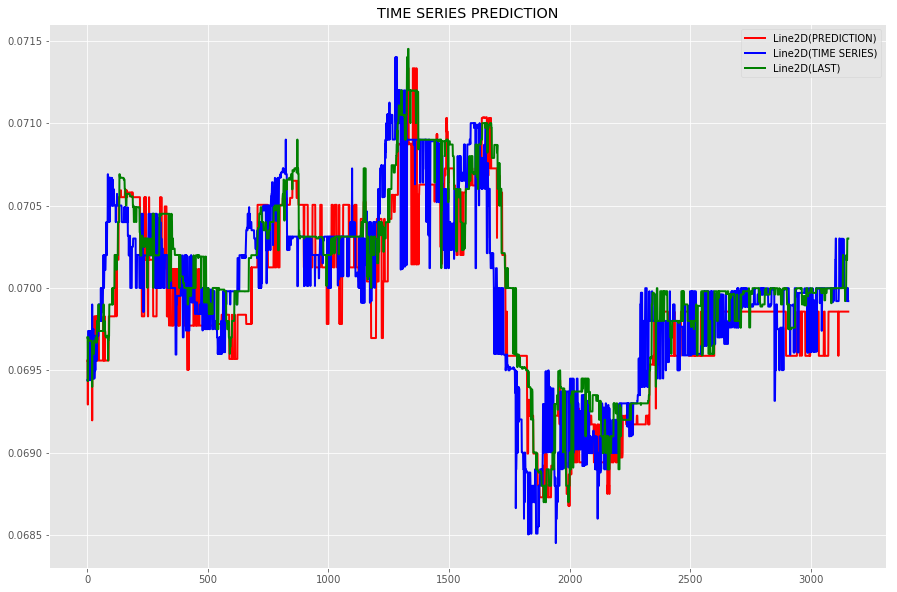

In [30]:
for i in range(n_predictions):
    trainX[i], testX[i], trainY[i], testY[i] = get_train_test_scaled_datasets(scaled_X_dataset_np[i], scaled_Y_dataset_np[i])
    # We train only with the latest days to avoid overfitting
    trainX[i], trainY[i] = trainX[i][:], trainY[i][:]
    
    print(testX[i][:,current_price_ilocation])
    print(testY[i].shape)
    
#     xgb_reg[i] = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=100)
#     xgb_reg[i].fit(trainX[i], trainY[i])
    xgb_reg[i] = xgb.XGBRegressor()

    clf[i] = GridSearchCV(xgb_reg[i],
               {'max_depth': [2,4,6],
                'n_estimators': [50,100,200]}, verbose=1)
    clf[i].fit(trainX[i], trainY[i])
    print(clf[i].best_score_)
    print(clf[i].best_params_)
    
    joblib.dump(clf[i], 
            '../models/latest/random_forest_regressor/xgboost_cv_clf_regressor_{}_{}_{}_{}_{}_fileslb_{}_datalb_{}_predictlf_{}.pkl'.format(
                pair, feature_selector, n_columns_f_selection, y_select[i], yesterday.strftime('%Y%m%d'), days_back_file*-1, datapoints_back, y_select[i]))
    
#     trainPredict[i] = xgb_reg[i].predict(trainX[i])
#     testPredict[i] = xgb_reg[i].predict(testX[i])
    trainPredict[i] = clf[i].predict(trainX[i])
    testPredict[i] = clf[i].predict(testX[i])
    
    trainPredict[i] = scaler_Y[i].inverse_transform(trainPredict[i])
    trainX[i] = scaler_X[i].inverse_transform(trainX[i])
    trainY[i] = scaler_Y[i].inverse_transform(trainY[i])
    testPredict[i] = scaler_Y[i].inverse_transform(testPredict[i])
    testX[i] = scaler_X[i].inverse_transform(testX[i])
    testY[i] = scaler_Y[i].inverse_transform(testY[i])
    
    print (testPredict[i].shape)
    
    # calculate root mean squared error
    trainScore[i] = math.sqrt(mean_squared_error(trainY[i][:,0], trainPredict[i]))
    print('Train Score: %.5f RMSE' % (trainScore[i]))
    testScore[i] = math.sqrt(mean_squared_error(testY[i][:,0], testPredict[i]))
    print('Test Score: %.5f RMSE' % (testScore[i]))
    
    pd_validation_xgb[i] = pd.DataFrame({'predicted': testPredict[i], \
                                  'actual': testY[i][:,0], 'last': testX[i][:, current_price_ilocation[i]]})
    
    print(pd_validation_xgb[i].head(10))
    
    plt.figure(figsize=(15,10))
    line1,=plt.plot(pd_validation_xgb[i]['predicted'],linewidth=2,color='r',label='PREDICTION')
    line2,=plt.plot(pd_validation_xgb[i]['actual'],linewidth=2,color='b',label='TIME SERIES')
    line3,=plt.plot(pd_validation_xgb[i]['last'],linewidth=2,color='g',label='LAST')
    plt.title("TIME SERIES PREDICTION")
    plt.legend([line1, line2, line3])
    plt.show()


### RNN REGRESSION

In [31]:
import os
os.environ["KERAS_BACKEND"] = "theano"
import keras; import keras.backend
if keras.backend.backend() != 'theano':
    raise BaseException("This script uses other backend")
else:
    keras.backend.set_image_dim_ordering('th')
    print("Backend ok")

Using Theano backend.


Backend ok


In [32]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import backend as K
import keras.callbacks
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
#from keras.regularizers import l2#, activity_l2
from keras import regularizers
from keras.layers import deserialize as layer_from_config
from scipy.interpolate import spline
import math

In [33]:
def predict_plot_rnn_model(_scaler_X, _scaler_Y, _scaled_X_dataset_np, _scaled_Y_dataset_np, _days_back, _datapoints_back, 
                           _n_layers, _n_epochs, _nunits, _datapoints_forward_prediction,
                          _pair, _feature_selector, x_n_columns, _y_select, _yesterday_str,
                          _current_price_ilocation):
    _trainX, _testX, _trainY, _testY = get_train_test_scaled_datasets(_scaled_X_dataset_np, _scaled_Y_dataset_np)
    _trainX[i], _trainY[i] = _trainX[i][:], _trainY[i][:]
    _trainX = np.reshape(_trainX, (_trainX.shape[0], 1, _trainX.shape[1]))
    _testX =  np.reshape(_testX, (_testX.shape[0], 1, _testX.shape[1]))
    batch_size = 1

    _model = Sequential()
    
    for _ in range(_n_layers):
        _model.add(LSTM(_nunits, input_shape=_trainX.shape[1:], return_sequences=True))
    
    _model.add(LSTM(_nunits, input_shape=_trainX.shape[1:]))
    _model.add(Dense(1))
    
    _model.compile(loss='mean_squared_error', optimizer='adam')
    _model.fit(_trainX, _trainY, epochs=_n_epochs, batch_size=1, verbose=2)
#     _model = keras.models.load_model('../models/latest/rnn_regressor/rnn_regressor_{}_{}_{}_{}_{}_fileslb_{}_datalb_{}_predictlf_{}_l{}_e{}.h5'.format(
#                 _pair, _feature_selector, x_n_columns, _y_select, _yesterday_str, _days_back*-1, _datapoints_back, _datapoints_forward_prediction, _n_layers, _n_epochs))
        
    _trainPredict = _model.predict(_trainX)
    _testPredict = _model.predict(_testX)
    
    _trainX = np.reshape(_trainX, (_trainX.shape[0], _trainX.shape[2]))
    _testX =  np.reshape(_testX, (_testX.shape[0], _testX.shape[2]))
    _trainPredict = _scaler_Y.inverse_transform(_trainPredict)
    _trainX = _scaler_X.inverse_transform(_trainX)
    _trainY = _scaler_Y.inverse_transform(_trainY)
    _testPredict = _scaler_Y.inverse_transform(_testPredict)
    _testX = _scaler_X.inverse_transform(_testX)
    _testY = _scaler_Y.inverse_transform(_testY)
    
    # calculate root mean squared error
    _trainScore = math.sqrt(mean_squared_error(_trainY[:,0], _trainPredict))
    print('Train Score: %.5f RMSE' % (_trainScore))
    _testScore = math.sqrt(mean_squared_error(_testY[:,0], _testPredict))
    print('Test Score: %.5f RMSE' % (_testScore))
    
    _pd_validation = pd.DataFrame({'predicted': _testPredict[:,0], \
                                  'actual': _testY[:,0], 'last': _testX[:,_current_price_ilocation]})
    
    plt.figure(figsize=(15,10))
    line1,=plt.plot(_pd_validation['predicted'],linewidth=2,color='r',label='PREDICTION')
    line2,=plt.plot(_pd_validation['actual'],linewidth=2,color='b',label='TIME SERIES')
    line3,=plt.plot(_pd_validation['last'],linewidth=2,color='g',label='LAST')
    plt.title("TIME SERIES PREDICTION")
    plt.legend([line1, line2, line3])
    plt.show()
    
    return _model, _pd_validation

In [34]:
model_l1_e5 = [None] * n_predictions
pd_validation_l1_e5 = [None] * n_predictions

(315616, 50)


WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


Epoch 1/2
529s - loss: 5.7416e-05
Epoch 2/2
683s - loss: 2.8491e-05
Train Score: 0.00019 RMSE
Test Score: 0.00016 RMSE


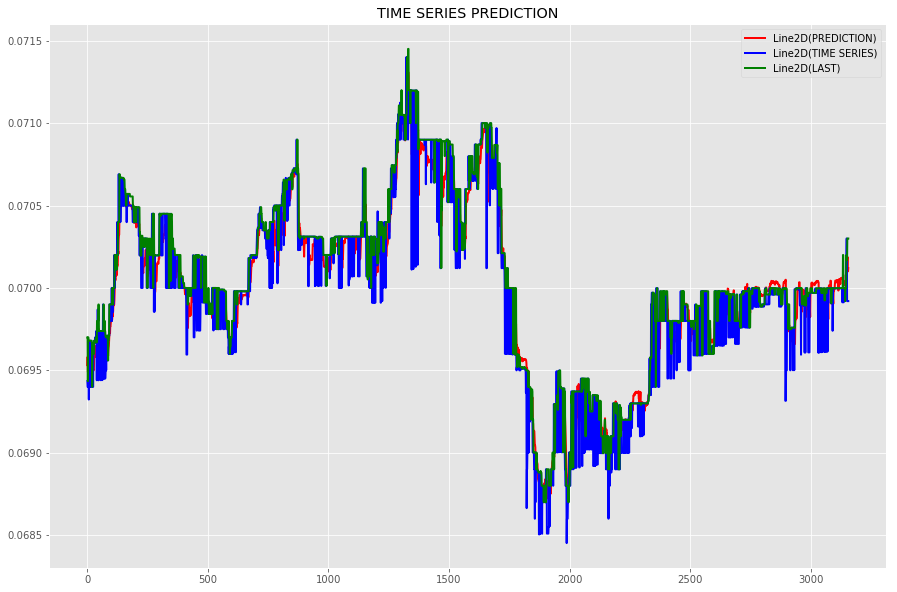

(315616, 50)
Epoch 1/2
577s - loss: 7.0955e-05
Epoch 2/2
765s - loss: 4.0015e-05
Train Score: 0.00022 RMSE
Test Score: 0.00019 RMSE


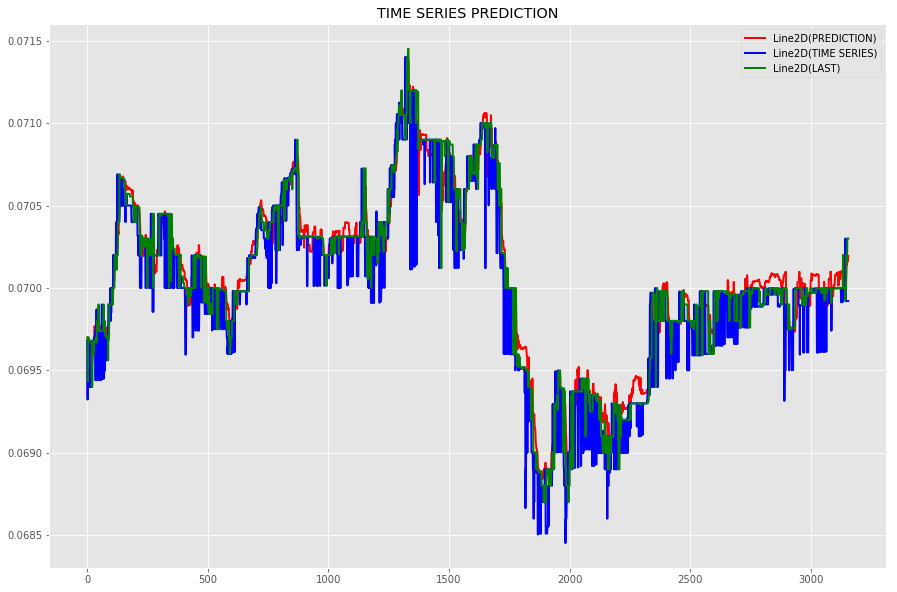

(315616, 50)
Epoch 1/2
590s - loss: 8.6983e-05
Epoch 2/2
715s - loss: 5.3453e-05
Train Score: 0.00025 RMSE
Test Score: 0.00020 RMSE


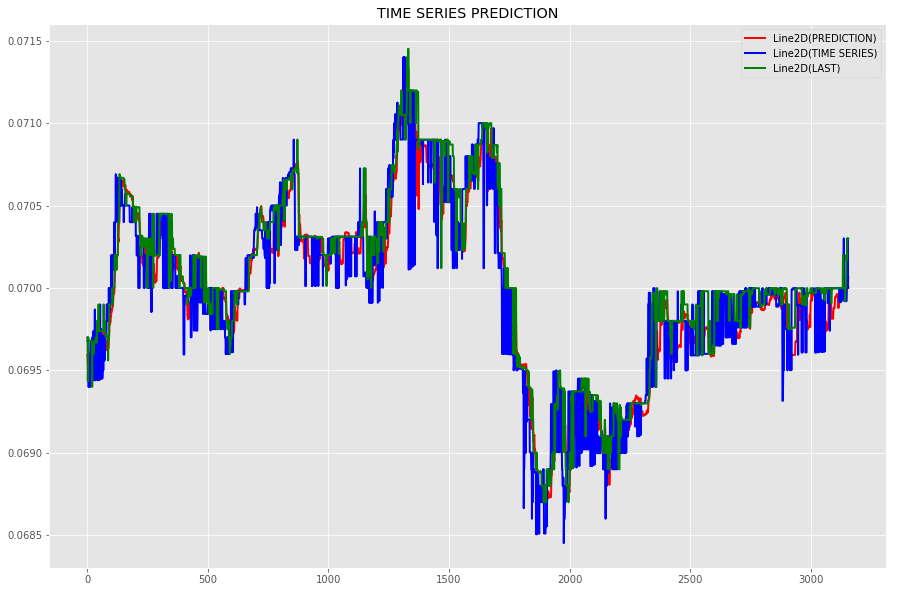

(315616, 50)
Epoch 1/2
587s - loss: 1.0717e-04
Epoch 2/2
774s - loss: 7.0873e-05
Train Score: 0.00031 RMSE
Test Score: 0.00023 RMSE


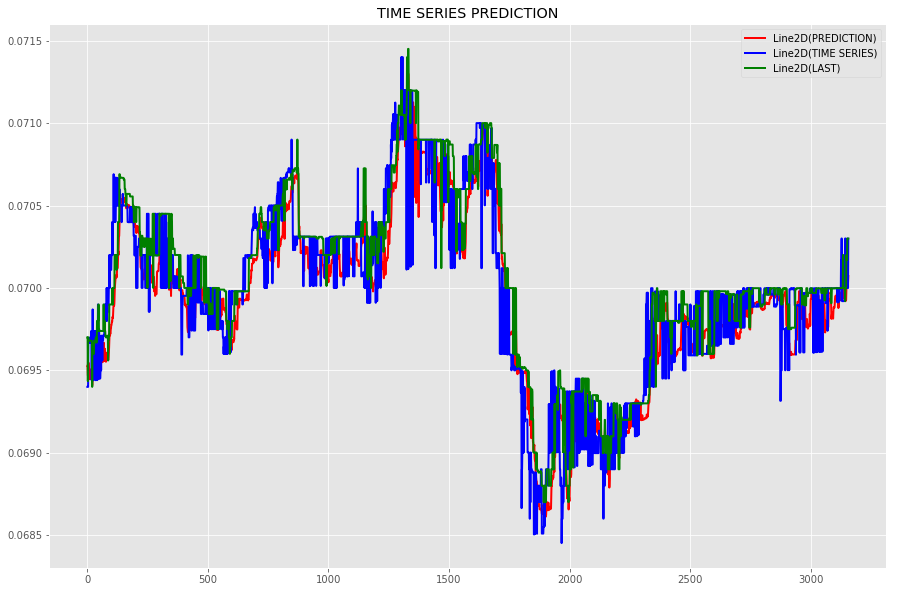

(315616, 50)
Epoch 1/2
610s - loss: 1.2978e-04
Epoch 2/2
778s - loss: 9.1054e-05
Train Score: 0.00037 RMSE
Test Score: 0.00031 RMSE


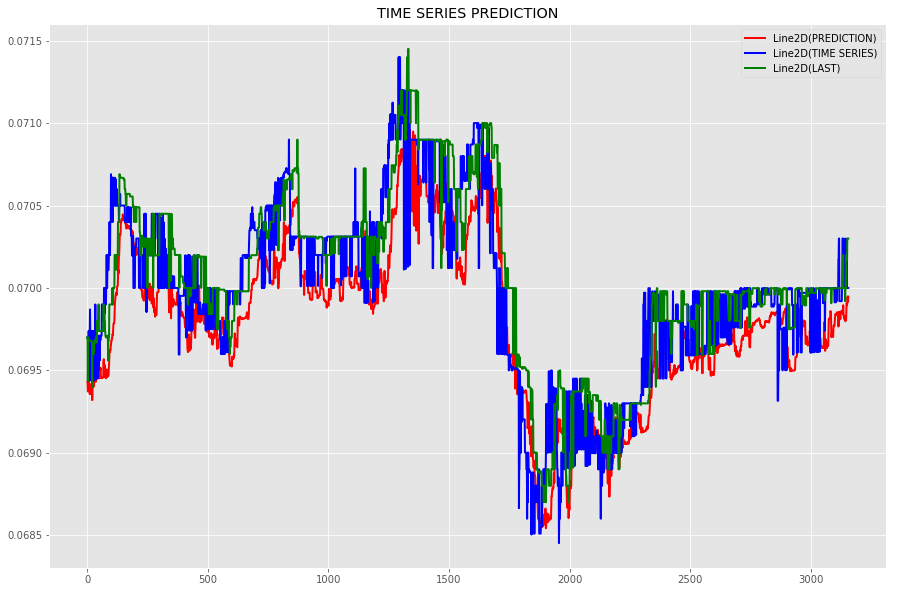

(315616, 50)
Epoch 1/2
560s - loss: 1.5822e-04
Epoch 2/2
745s - loss: 1.1283e-04
Train Score: 0.00039 RMSE
Test Score: 0.00031 RMSE


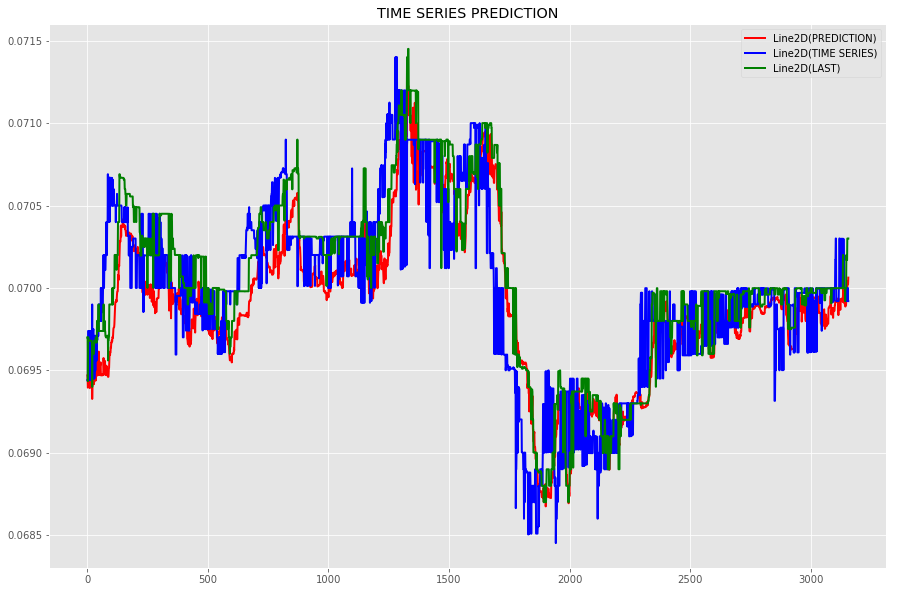

In [35]:
for i in range(n_predictions):
    print(scaled_X_dataset_np[i].shape)
    
    model_l1_e5[i], pd_validation_l1_e5[i] = predict_plot_rnn_model(scaler_X[i], scaler_Y[i], scaled_X_dataset_np[i], scaled_Y_dataset_np[i], 
                                                          days_back_file, datapoints_back, 1, 2, 50,
                                                          y_select[i], pair, 
                                                          feature_selector, X_new[i].shape[1], y_select[i], 
                                                          yesterday.strftime('%Y%m%d'), current_price_ilocation[i])

### REALTIME INFERENCE

In [36]:
@retry(wait_exponential_multiplier=1000, wait_exponential_max=60000, stop_max_delay=1800000)
def returnTickerAll(exchange):

    if exchange == 'POLONIEX':
        return json.loads(ccs.poloniex.public.returnTicker())
    elif exchange == 'BITTREX':
        # We need to transform it in a dictionary:
        initial_list = json.loads(ccs.bittrex.public.getMarketSummaries())['result']
        markets = {}

        for market in initial_list:
            markets[str(market['MarketName']).replace('-', '_')] = market

        return markets

    else:
        printEvent('Unknown exchange: {}'.format(exchange), "STOPPED_APPLICATION", 4, exchange)
        sys.exit(-1)

In [37]:
def create_np_array(_dequeue, _datapoints_back, _datapoints_forward_predictionm):
    current = _dequeue[0]
    prev_list = []
    
    current_list = [current['Ask'], current['BaseVolume'], current['Bid'], current['High'], current['Last'],
                    current['Low'], current['OpenBuyOrders'], current['OpenSellOrders'], current['PrevDay'], 
                    current['Volume']]
    
    for cohort in range(int(_datapoints_back/3)):
        #p_1, p_2, p_3 = cohort*3 + 1, cohort*3 + 2, cohort*3 + 3
        p_1, p_2, p_3 = 1 + cohort*63, 2 + 6 + cohort*63, 3 + 18 + cohort*63
        
#         p_1_real_jump = p_1 + cohort*60
#         p_2_real_jump = p_2 + 6 + cohort*60
#         p_3_real_jump = p_3 + 18 + cohort*60
        
        cohort_list = [_dequeue[p_1]['Ask'], _dequeue[p_2]['Ask'], _dequeue[p_3]['Ask'],\
                      _dequeue[p_1]['BaseVolume'], _dequeue[p_2]['BaseVolume'], _dequeue[p_3]['BaseVolume'],\
                       _dequeue[p_1]['Bid'], _dequeue[p_2]['Bid'], _dequeue[p_3]['Bid'],\
                      _dequeue[p_1]['High'], _dequeue[p_2]['High'], _dequeue[p_3]['High'],\
                       _dequeue[p_1]['Last'], _dequeue[p_2]['Last'], _dequeue[p_3]['Last'],\
                      _dequeue[p_1]['Low'], _dequeue[p_2]['Low'], _dequeue[p_3]['Low'],\
                       _dequeue[p_1]['OpenBuyOrders'], _dequeue[p_2]['OpenBuyOrders'], _dequeue[p_3]['OpenBuyOrders'],\
                      _dequeue[p_1]['OpenSellOrders'], _dequeue[p_2]['OpenSellOrders'], _dequeue[p_3]['OpenSellOrders'],\
                       _dequeue[p_1]['PrevDay'], _dequeue[p_2]['PrevDay'], _dequeue[p_3]['PrevDay'],\
                      _dequeue[p_1]['Volume'], _dequeue[p_2]['Volume'], _dequeue[p_3]['Volume']]
        prev_list += cohort_list
   
    

    return np.asarray(current_list + prev_list)

In [38]:
import warnings
warnings.filterwarnings('ignore')

In [39]:
def predict(_f_selector_mdl, _scaler_X, _scaler_Y, _model_rnn, _forest_reg, xgb_reg, _recent_data_points):
    _X_new = _f_selector_mdl.transform(_recent_data_points)
    scaled_recent_data_points = _scaler_X.transform(_X_new)
    predicted_recent_rf_scaled = _forest_reg.predict(scaled_recent_data_points)
    predicted_recent_xgb_scaled = xgb_reg.predict(scaled_recent_data_points)

    scaled_recent_data_points_pres = scaled_recent_data_points #scaled_recent_data_points.reshape(1, scaled_recent_data_points.shape[0])
    
    scaled_recent_data_points_rnn = np.reshape(scaled_recent_data_points_pres, 
                                               (scaled_recent_data_points_pres.shape[0], 1, 
                                                scaled_recent_data_points_pres.shape[1]))


    predicted_recent_rnn_scaled = _model_rnn.predict(scaled_recent_data_points_rnn)
    _predicted_recent_rf = _scaler_Y.inverse_transform(predicted_recent_rf_scaled)
    _predicted_recent_rnn = _scaler_Y.inverse_transform(predicted_recent_rnn_scaled)
    _predicted_recent_xgb = _scaler_Y.inverse_transform(predicted_recent_xgb_scaled)


    return (_predicted_recent_rf, _predicted_recent_rnn, _predicted_recent_xgb)

In [58]:
import collections
import time
import pymongo
from bson import json_util
from bson.json_util import dumps, loads
from pymongo import MongoClient

real_data_points_back = (n_hops_back*3)*60
data_window = collections.deque(maxlen=real_data_points_back*18)
predictions = collections.deque(maxlen=real_data_points_back*18)

client = MongoClient('mongodb://172.17.0.3:27017/')
mydb = client.etherchainmldb

# 900 datapoints => 9000 seconds (+1800 seconds safe)-> 3 hours ago.
# results = mydb.predictions.find({"modelType": "dummy", "currencyPair": "BTC-NMR"})
delta_ts = datetime.utcnow() - datetime(1970, 1, 1)
beginning_of_window = int((delta_ts.days * 24 * 60 * 60 + delta_ts.seconds) * 1000 + delta_ts.microseconds / 1000.0) \
    - 10800000
print(beginning_of_window)
results = mydb.bittrex_ticker.find({"MarketName": "BTC-ETH", "TimeStampEpoch": {"$gt": beginning_of_window}})
print(results.count())
print(results[0])


1501589370772
988
{'_id': ObjectId('59806f8e411bf4054e3108a4'), 'Low': 0.0675, 'TimeStamp': '2017-08-01T12:09:40.563', 'BaseVolume': 4641.77265665, 'Bid': 0.07173099, 'High': 0.07705, 'Created': '2015-08-14T09:02:24.817', 'OpenBuyOrders': 2802, 'Volume': 64457.57647019, 'PrevDay': 0.06894, 'TimeStampEpoch': 1501589380563, 'Ask': 0.071732, 'ClientTimeStampEpoch': 1501589390065, 'OpenSellOrders': 12853, 'MarketName': 'BTC-ETH', 'Last': 0.071732}


In [59]:
sorted_results = sorted(results, key=lambda x: x['TimeStampEpoch'], reverse=False)

In [60]:
#for _ in range(real_data_points_back):
for current_data in sorted_results[-real_data_points_back:]:
    #current_data = returnTickerAll('BITTREX')[pair.replace('-', '_')]
    data_window.appendleft(current_data)
    print('Adding {} data for past window'.format(current_data))

Adding {'_id': ObjectId('5980731d411bf4054e3108fc'), 'Low': 0.0675, 'TimeStamp': '2017-08-01T12:24:52.76', 'BaseVolume': 4903.04791862, 'Bid': 0.07701821, 'High': 0.0777, 'Created': '2015-08-14T09:02:24.817', 'OpenBuyOrders': 2843, 'Volume': 67913.152401, 'PrevDay': 0.06894003, 'TimeStampEpoch': 1501590292760, 'Ask': 0.0777, 'ClientTimeStampEpoch': 1501590301265, 'OpenSellOrders': 12584, 'MarketName': 'BTC-ETH', 'Last': 0.0777} data for past window
Adding {'_id': ObjectId('59807327411bf4054e3108fd'), 'Low': 0.0675, 'TimeStamp': '2017-08-01T12:24:55.463', 'BaseVolume': 4903.06670354, 'Bid': 0.07701821, 'High': 0.0777, 'Created': '2015-08-14T09:02:24.817', 'OpenBuyOrders': 2842, 'Volume': 67913.39630343, 'PrevDay': 0.06894003, 'TimeStampEpoch': 1501590295463, 'Ask': 0.0777, 'ClientTimeStampEpoch': 1501590311682, 'OpenSellOrders': 12585, 'MarketName': 'BTC-ETH', 'Last': 0.07701821} data for past window
Adding {'_id': ObjectId('59807331411bf4054e3108fe'), 'Low': 0.0675, 'TimeStamp': '2017-

In [61]:
len(data_window)

900

In [62]:
real_data_points_back

900

In [63]:
from datetime import datetime

In [64]:
str(datetime.now())

'2017-08-01 15:09:35.567409'

In [65]:
predicted_recent_rf = [None] * n_predictions
predicted_recent_rnn = [None] * n_predictions
predicted_recent_xgb = [None] * n_predictions

In [66]:
for _ in range(real_data_points_back*18):
    current_data = returnTickerAll('BITTREX')[pair.replace('-', '_')]
    data_window.appendleft(current_data)
    recent_data_points = create_np_array(data_window, datapoints_back, datapoints_forward_prediction)
    
    for i in range(n_predictions):
        predicted_recent_rf[i], predicted_recent_rnn[i], predicted_recent_xgb[i] = predict(f_selector_mdl[i], 
                                scaler_X[i], scaler_Y[i], model_l1_e5[i], forest_reg[i], clf[i], recent_data_points)
    
    tuple = (str(datetime.now()), current_data['Last'], predicted_recent_rf[0][0], predicted_recent_rnn[0][0][0], 
             predicted_recent_xgb[0][0], predicted_recent_rf[1][0], predicted_recent_rnn[1][0][0], 
             predicted_recent_xgb[1][0], predicted_recent_rf[2][0], predicted_recent_rnn[2][0][0], 
             predicted_recent_xgb[2][0], predicted_recent_rf[3][0], predicted_recent_rnn[3][0][0], 
             predicted_recent_xgb[3][0], predicted_recent_rf[4][0], predicted_recent_rnn[4][0][0], 
             predicted_recent_xgb[4][0], predicted_recent_rf[5][0], predicted_recent_rnn[5][0][0],
             predicted_recent_xgb[5][0])
    
    for p in range(3, 20):
        delta = (tuple[p]-tuple[2])/tuple[2]
        
        if(math.fabs(delta)>=0.007):
            print('Significant Delta: {}. Prediction position: {}. Current: {}. Prediction: {}'.format(delta, p, tuple[2], tuple[p]))
    
    predictions.appendleft(tuple)
    print(tuple)
    
    time.sleep(10)
    
  

('2017-08-01 15:09:37.171431', 0.08055011, 0.08066117265467096, 0.080538213, 0.080668822, 0.080649962261343244, 0.080758907, 0.08075089, 0.080837243997556263, 0.080776349, 0.080612339, 0.080704873155487952, 0.080729328, 0.080694206, 0.080964137728362529, 0.080648035, 0.080729842, 0.081008923033615565, 0.080794685, 0.080743194)
('2017-08-01 15:09:47.369414', 0.08055011, 0.080655136987973414, 0.080535419, 0.080669306, 0.080627429172775281, 0.080757439, 0.08075089, 0.080837243997556263, 0.080775723, 0.080612339, 0.080704873155487952, 0.080730267, 0.080694206, 0.080901946678297157, 0.080649585, 0.080729842, 0.081007191396087391, 0.08079771, 0.080743194)
('2017-08-01 15:09:57.815381', 0.08055011, 0.080615375525682154, 0.080567569, 0.080669306, 0.080692635939213803, 0.08080817, 0.080765955, 0.080857225684301606, 0.080831006, 0.080612339, 0.080674652035238451, 0.080786161, 0.080694206, 0.080963631461630214, 0.080709331, 0.080729842, 0.081009665305655454, 0.080882654, 0.080743194)
('2017-08-01

KeyboardInterrupt: 

In [67]:
list(predictions)

[('2017-08-01 18:33:47.299133',
  0.08118798,
  0.081165602768856357,
  0.080987804,
  0.081170119,
  0.081258233872558094,
  0.081181966,
  0.081210971,
  0.081190657596612051,
  0.081212342,
  0.081029668,
  0.081201229208105283,
  0.081159398,
  0.081152588,
  0.081100265259785642,
  0.081049815,
  0.081032507,
  0.080996512310812327,
  0.081157587,
  0.081123315),
 ('2017-08-01 18:33:36.992480',
  0.08118798,
  0.081172867944149713,
  0.080990121,
  0.081170119,
  0.081252523774541882,
  0.081180073,
  0.081210971,
  0.081184302355867141,
  0.081210025,
  0.081029668,
  0.08137022106678371,
  0.081155695,
  0.081152588,
  0.081173675671531789,
  0.081046864,
  0.081032507,
  0.081030005834904939,
  0.081156172,
  0.081123315),
 ('2017-08-01 18:33:26.567078',
  0.0812,
  0.081167498936114565,
  0.080988362,
  0.081169039,
  0.081251468459893575,
  0.08117035,
  0.081201293,
  0.081176020117045083,
  0.081198767,
  0.081029668,
  0.081292223470036409,
  0.081141919,
  0.081138536,
  

In [68]:
predictions_2 = predictions

In [69]:
# predictions_1 = predictions

In [70]:
# len(predictions_0)

In [71]:
# pr_sorted_0 = sorted(list(predictions_0))

In [72]:
df_1 = pd.DataFrame(sorted(list(predictions_2)), columns=['ts_utc', 'last', 'predicted_mdl_rf_1',
                                          'predicted_mdl_rnn_1', 'predicted_mdl_xgb_1', 
                                         'predicted_mdl_rf_2', 'predicted_mdl_rnn_2', 'predicted_mdl_xgb_2',
                                        'predicted_mdl_rf_3', 'predicted_mdl_rnn_3', 'predicted_mdl_xgb_3', 
                                        'predicted_mdl_rf_4', 'predicted_mdl_rnn_4', 'predicted_mdl_xgb_4', 
                                        'predicted_mdl_rf_5', 'predicted_mdl_rnn_5', 'predicted_mdl_xgb_5', 
                                        'predicted_mdl_rf_6', 'predicted_mdl_rnn_6', 'predicted_mdl_xgb_6'])

In [73]:
# df_0.to_csv('../data/allticker_bittrex_prediction_{}_{}_{}_fileslb_{}_datalb_{}_g0.csv.gz'.format(
#                 pair, n_columns_original_data, yesterday.strftime('%Y%m%d'), days_back_file*-1, datapoints_back), index=False, compression='gzip')

df_1.to_csv('../data/allticker_bittrex_prediction_{}_{}_{}_fileslb_{}_datalb_{}_xgb8.csv.gz'.format(
                pair, n_columns_original_data, yesterday.strftime('%Y%m%d'), days_back_file*-1, datapoints_back), index=False, compression='gzip')